# Import modules

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering

import warnings
warnings.simplefilter('ignore')

# Read in data

In [2]:
df = pd.read_csv('whisky_clean.csv',index_col=0)
df_orig = df.copy()

# Describe data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 0 to 80
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Distillery  81 non-null     object 
 1   Body        81 non-null     int64  
 2   Sweetness   81 non-null     int64  
 3   Smoky       81 non-null     int64  
 4   Medicinal   81 non-null     int64  
 5   Tobacco     81 non-null     int64  
 6   Honey       81 non-null     int64  
 7   Spicy       81 non-null     int64  
 8   Winey       81 non-null     int64  
 9   Nutty       81 non-null     int64  
 10  Malty       81 non-null     int64  
 11  Fruity      81 non-null     int64  
 12  Floral      81 non-null     int64  
 13  x           81 non-null     float64
 14  y           81 non-null     float64
dtypes: float64(2), int64(12), object(1)
memory usage: 9.8+ KB


In [4]:
df.head()

,Distillery,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral,x,y
0,Aberfeldy,2,2,2,0,0,2,1,2,2,2,2,2,161.631967,159.196369
1,Aberlour,3,3,1,0,0,4,3,2,2,3,3,2,203.945680,235.307777
2,Ardbeg,4,1,4,4,0,0,2,0,1,2,1,0,14.327041,80.771859
3,Ardmore,2,2,2,0,0,1,1,1,2,3,1,1,232.450057,222.859796
4,ArranIsleOf,2,3,1,1,0,1,1,1,0,1,1,2,66.625977,81.029302


# Explore data

In [5]:
import numpy as np

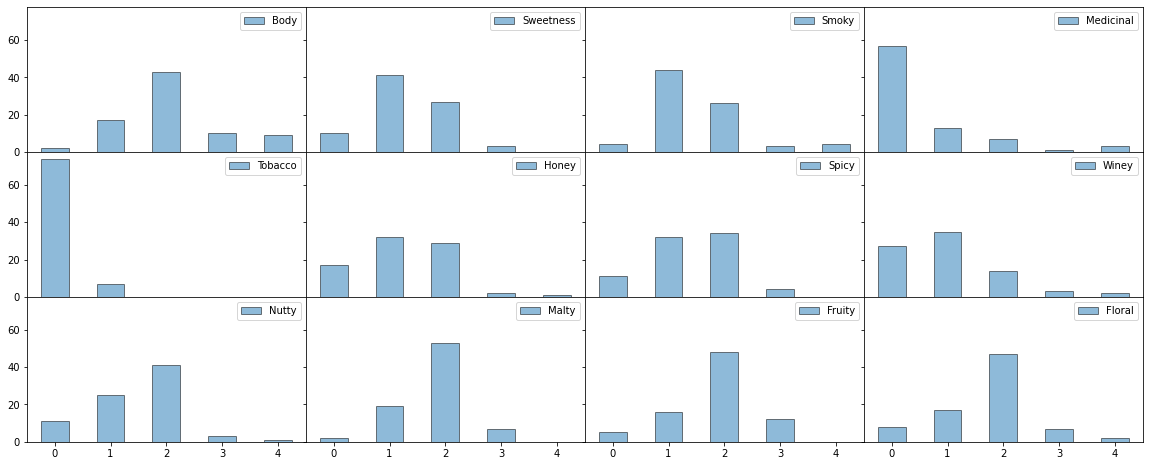

In [6]:
df_plot = df.iloc[:,1:-2]
fig,ax=plt.subplots(3,4,figsize=(20,8),sharey=True,sharex=True)

for i,a in enumerate(ax.flatten()):
    df_temp = df_plot.iloc[:,i]
    df_temp.value_counts().sort_index().plot.bar(ax=a,label=df_temp.name,alpha=0.5,ec='k')
    a.legend()
    a.tick_params(rotation=0)
plt.subplots_adjust(hspace=0.0,wspace=0.0)

Text(0.5, 1.0, 'Kendall')

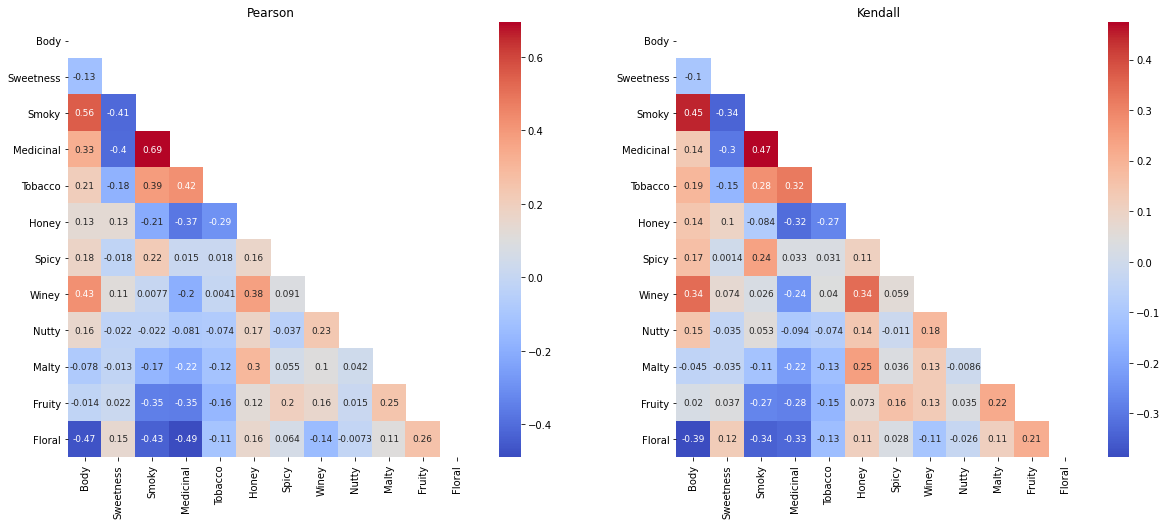

In [7]:
corr_p=df.iloc[:,1:-2].corr(method='pearson')
corr_s=df.iloc[:,1:-2].corr(method='kendall') # ordinal association
mask = np.triu(np.ones(corr_p.shape,dtype=bool))

fig,ax=plt.subplots(1,2,figsize=(20,8))
sns.heatmap(corr_p,annot=True,cmap='coolwarm',mask=mask,ax=ax[0],annot_kws={"size":9})
sns.heatmap(corr_s,annot=True,cmap='coolwarm',mask=mask,ax=ax[1],annot_kws={"size":9})
ax[0].set_title('Pearson')
ax[1].set_title('Kendall')

In [8]:
# convert heat map into ordered dataframe
corr_p_res = corr_p.where(~mask).stack().reset_index().rename(columns={'level_0':'feature 1','level_1':'feature 2',0:'r'})
corr_p_res.loc[corr_p_res['r']>0,'corr']='p'
corr_p_res.loc[corr_p_res['r']<0,'corr']='n'
corr_p_res.loc[corr_p_res['r']==0,'corr']='o'
corr_p_res['r'] = abs(corr_p_res['r'])
corr_p_res = corr_p_res.sort_values(by='r',ascending=False).reset_index(drop=True)
corr_p_res.head(10)

,feature 1,feature 2,r,corr
0,Medicinal,Smoky,0.694259,p
1,Smoky,Body,0.555072,p
2,Floral,Medicinal,0.490085,n
3,Floral,Body,0.470946,n
4,Floral,Smoky,0.432364,n
5,Winey,Body,0.425606,p
6,Tobacco,Medicinal,0.424418,p
7,Smoky,Sweetness,0.409320,n
8,Medicinal,Sweetness,0.402948,n
9,Tobacco,Smoky,0.390839,p


# Analysis

In [9]:
def estimtate_KM_clusters(X,sil_range=[2,30]):
    i_score=[]
    s_score=[]
    clusters = list(map(int,np.linspace(2,31,30)))
    for n in clusters:
        km = KMeans(n_clusters=n)
        km.fit(X)
        s_score.append(silhouette_score(X,km.labels_))
        i_score.append(km.inertia_)

    fig,ax = plt.subplots(1,2,figsize=(18,4))
    ax[0].set_title('Intertia')
    ax[0].plot(clusters,i_score)
    ax[1].set_title('Silhouette score')
    ax[1].plot(clusters,s_score)
    r = list(map(list,zip(clusters,s_score)))[sil_range[0]-2:sil_range[1]-2]
    x,y = max(r,key=lambda x: x[1])
    ax[1].text(x,y*1.01,round(x,1),c='red')
    plt.show()

In [10]:
X = df.iloc[:,1:-2]

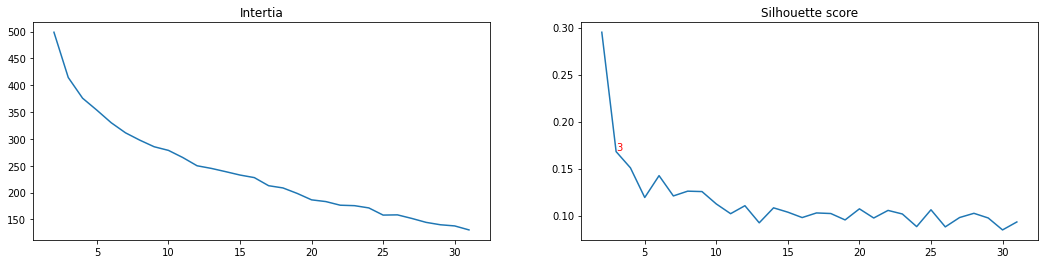

In [11]:
estimtate_KM_clusters(X,[3,15])

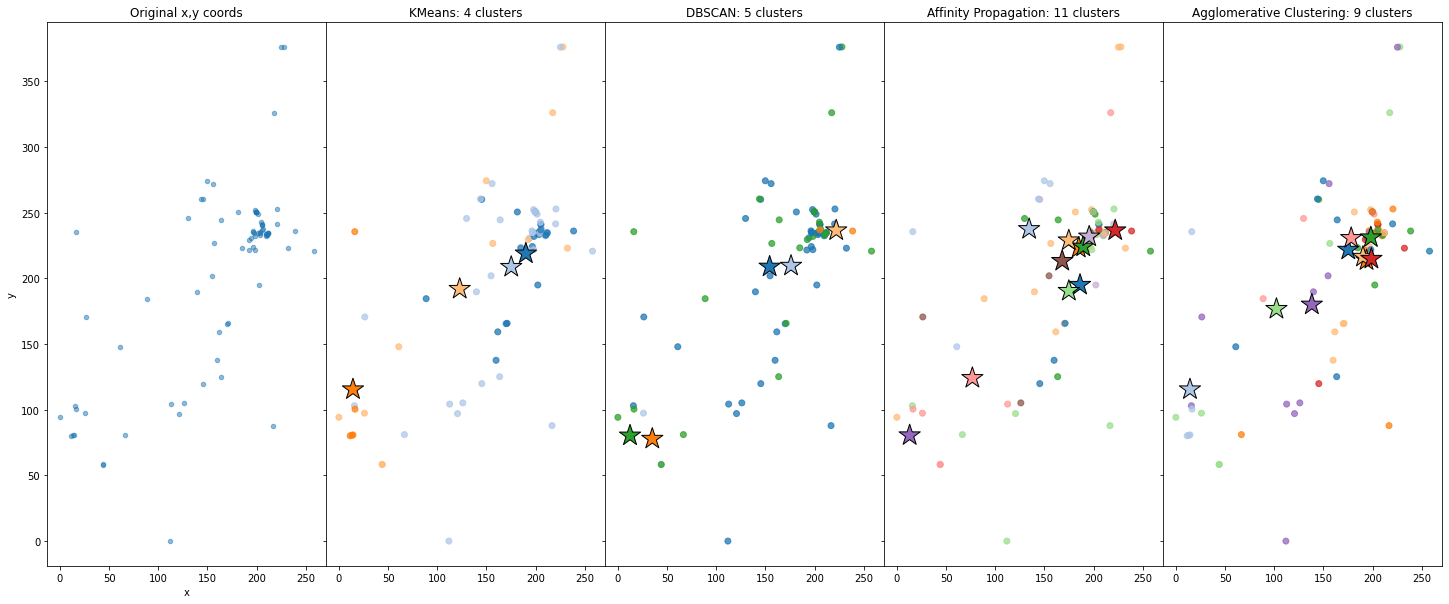

In [12]:
algorithms = {'KMeans':                   KMeans(n_clusters=4),
              'DBSCAN':                   DBSCAN(eps=2,min_samples=2,metric='euclidean'),
              'Affinity Propagation':     AffinityPropagation(),
              'Agglomerative Clustering': AgglomerativeClustering(n_clusters=9)}

fig,ax = plt.subplots(1,5,figsize=(25,10),sharey=True)
cmap = plt.get_cmap('tab20')

all_labels = {}
for i,items in enumerate(algorithms.items()):
    name, algorithm = items
    algorithm.fit(X)
    if hasattr(algorithm, 'labels_'):
            labels = algorithm.labels_
            # get colors
            unique_labels = set(labels)
            colors = cmap(np.arange(len(unique_labels)))
            color_dict = dict(map(list,zip(unique_labels,colors)))
            label_colors = [color_dict[l] for l in labels]
            all_labels[name+'_labels'] = labels
    X_labels = pd.concat([df,pd.Series(labels,name='label')],axis=1)
    df_centers = X_labels.groupby('label').mean()
    
    ax[i+1].scatter(x=df['x'],y=df['y'],marker='o',alpha=0.75,label=None,zorder=1,color=label_colors)
    ax[i+1].scatter(df_centers['x'],df_centers['y'],marker='*',s=500,ec='k',zorder=2,color=colors)
    ax[i+1].set_title(name+': '+str(len(unique_labels))+' clusters')
    
df.plot(kind='scatter',x='x',y='y',alpha=0.5,title='Original x,y coords',ax=ax[0])
plt.subplots_adjust(wspace=0.0)

# Cluster summaries

- Here we show the distrubtion of distilleries within in each cluster

In [13]:
df_labels = pd.concat([df,pd.DataFrame(all_labels)],axis=1)

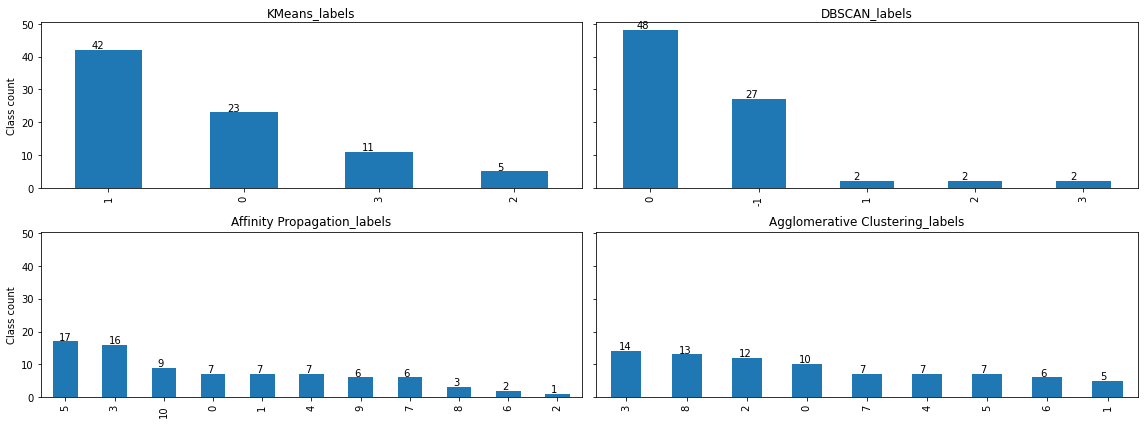

In [14]:
fig,ax=plt.subplots(2,2,figsize=(16,6),sharey=True)
ax=ax.flatten()
algs = df_labels.columns[-4:]
for n,a in enumerate(algs):
    df_plot = pd.concat([df_labels.iloc[:,:-6],df_labels[a]],axis=1)
    df_plot[a].value_counts().plot.bar(ax=ax[n],title=a)
    for p in ax[n].patches:
        x = p.get_x()
        y = p.get_height()
        ax[n].text(x=x+0.125,y=y+0.5,s=y,color='k')
        ax[n].set_ylabel('Class count')
plt.tight_layout()

## Distillary summary

- Next we show a sample of the distillery names for eachcluster, as chosen per alogrithm

In [15]:
def distillery_summary(s):
    ds = s['Distillery']
    count = '#{}: '.format(str(len(ds)))
    res = list(map(str.strip,ds.unique()))
    res = count+', '.join(res)
    return res

In [16]:
def flavour_summary(s):
    flavours = s.iloc[:,:-6].mean()
    res = list(flavours.sort_values(ascending=False).index)
    res = ', '.join(res[:4])+'...'
    return res

In [17]:
for col in all_labels.keys():
    print(df_labels.groupby(col).apply(distillery_summary))
    print('-'*55)

KMeans_labels
0    #23: Aberfeldy, Aberlour, Auchroisk, Balmenach...
1    #42: ArranIsleOf, Auchentoshan, Aultmore, Benr...
2    #5: Ardbeg, Caol Ila, Lagavulin, Laphroig, Tal...
3    #11: Ardmore, Balblair, Bruichladdich, GlenSco...
dtype: object
-------------------------------------------------------
DBSCAN_labels
-1    #27: Aberlour, Ardbeg, ArranIsleOf, Balmenach,...
 0    #48: Aberfeldy, Ardmore, Auchentoshan, Auchroi...
 1                         #2: GlenScotia, Isle of Jura
 2                            #2: Glendronach, Macallan
 3                              #2: Lagavulin, Laphroig
dtype: object
-------------------------------------------------------
Affinity Propagation_labels
0     #7: Auchroisk, Deanston, Edradour, GlenKeith, ...
1     #7: Balblair, Craigganmore, Glenmorangie, Oban...
2                                         #1: Balmenach
3     #16: Aberfeldy, Ardmore, BenNevis, Benrinnes, ...
4     #7: Belvenie, Benriach, GlenGarioch, GlenOrd, ...
5     #17: ArranIsleOf, 

## Flavour summary

- We now show the average flavour profile for each cluster, as chosed per algorithm

In [18]:
for col in all_labels.keys():
    print(df_labels.groupby(col).apply(flavour_summary))
    print('-'*55)

KMeans_labels
0      Body, Sweetness, Fruity, Malty...
1    Sweetness, Floral, Fruity, Malty...
2       Body, Smoky, Medicinal, Spicy...
3       Smoky, Body, Sweetness, Nutty...
dtype: object
-------------------------------------------------------
DBSCAN_labels
-1        Body, Sweetness, Smoky, Malty...
 0     Sweetness, Fruity, Floral, Malty...
 1        Body, Smoky, Medicinal, Nutty...
 2       Body, Winey, Sweetness, Fruity...
 3    Body, Smoky, Medicinal, Sweetness...
dtype: object
-------------------------------------------------------
Affinity Propagation_labels
0         Sweetness, Malty, Body, Nutty...
1        Sweetness, Body, Fruity, Spicy...
2         Body, Sweetness, Winey, Nutty...
3        Sweetness, Malty, Floral, Body...
4        Fruity, Body, Sweetness, Spicy...
5      Sweetness, Floral, Malty, Fruity...
6        Body, Winey, Sweetness, Fruity...
7         Smoky, Body, Medicinal, Nutty...
8     Body, Smoky, Medicinal, Sweetness...
9        Body, Fruity, Sweetness, Spic

## Most representative distilleries

- Finally, we show the distillery that is most representative of its given cluster, along with the flavour profile.
- Notice how this compares with the flavour profile for KMeans above.
- _This result has only been performed for KMeans._

In [19]:
from scipy.spatial import distance

km = algorithms['KMeans']
all_centers = km.cluster_centers_
cluster_dist_dict = {}
for label, cluster in df_labels.groupby('KMeans_labels'):
    cluster = cluster.iloc[:,1:-6]
    center = all_centers[label]
    idx = cluster.apply(lambda row: distance.euclidean(row,center),axis=1).idxmin()
    res = df_labels.loc[idx,'Distillery']
    cluster_dist_dict[label]=[idx,res]
idxs = [a[0] for a in cluster_dist_dict.values()]

In [20]:
df_labels.iloc[idxs,:-3].drop(columns=['x','y'])

,Distillery,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral,KMeans_labels
0,Aberfeldy,2,2,2,0,0,2,1,2,2,2,2,2,0
37,Glenallachie,1,3,1,0,0,1,1,0,1,2,2,2,1
2,Ardbeg,4,1,4,4,0,0,2,0,1,2,1,0,2
35,GlenScotia,2,2,2,2,0,1,0,1,2,2,1,1,3


In [21]:
# Does flavour correlate with geographical location?
    # visual check does not seem to indicat this to be true
    # can we use a more intelligent approach?

# Which flavours define each cluster?

# Which distillery is the most represetnative per cluster?

# Which model is the best?

# Further analysis

## PCA

- This next section aims to understand the data in more detail.
1. We first begin by performing dimenionsal reduction using PCA
    - this allows us to see the explained variance of the data - there is no benefit from model performance due to our small data set
2. We then perform classification using a decision tree classifier.
    - we will use the flavour proiles to predict our K-means cluster labels
    - this allows to see the 'rules' accosiated with decision which cluster a distillery belongs to
    - we evaluate the model using various metrics:
        - accuracy
        - precision and recall
        - ROC

In [22]:
from sklearn.decomposition import PCA

In [23]:
pca = PCA(n_components=12)
X = df.iloc[:,1:-2]
pca = pca.fit(X)

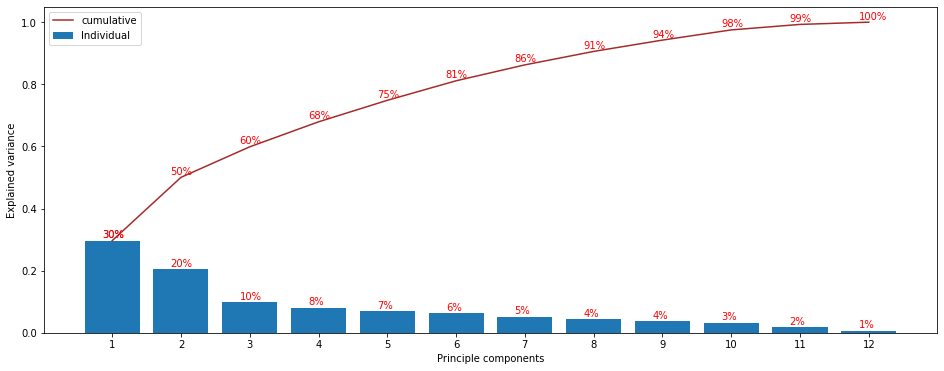

In [24]:
xs = np.linspace(1,12,12)
ys = pca.explained_variance_
ys = [y/ys.sum() for y in ys]
ys_cs = np.cumsum(ys)

fig,ax=plt.subplots(figsize=(16,6))
ax.bar(x=xs,height=ys,label='Individual')
ax.plot(xs,ys_cs,label='cumulative',color='brown')

for n,i in enumerate(ax.patches):
    x = i.get_x()
    y    = ys[n]
    y_cs = ys_cs[n]
    
    s    = str(int(round(100*y,0)))+'%'
    s_cs = str(int(round(100*y_cs,0)))+'%'
    
    ax.text(x=x+0.25,y=y+0.01,s=s,c='r')
    ax.text(x=x+0.25,y=y_cs+0.01,s=s_cs,c='r')
ax.set_xlabel('Principle components')
ax.set_ylabel('Explained variance')
ax.set_xticks(xs)
a = ax.legend()

## Create classification model

In [26]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report #, roc_auc_score

### Create tree and data

- create decision tree classifier model

In [27]:
tree = DecisionTreeClassifier(criterion='entropy')

- seperate input and target variables for training data

In [28]:
X = df.iloc[:,1:-2]
Y = df_labels.loc[:,'KMeans_labels']

### Grid search

- perform grid search on max depth and criterion

In [98]:
param_dict ={'max_depth':range(1,20),
             'min_samples_leaf':range(5,10),
             'criterion':['entropy','gini']}
grid = GridSearchCV(tree,param_dict,cv=5,scoring='accuracy')
grid.fit(X,Y)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              min_samples_leaf=0.5),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(1, 20),
                         'min_samples_leaf': range(5, 10)},
             scoring='accuracy')

In [81]:
grid.best_params_

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 6}

In [82]:
pd.DataFrame(grid.cv_results_).drop(columns=['params']).iloc[:,4:].sort_values(by='mean_test_score',ascending=False).head()

,param_criterion,param_max_depth,param_min_samples_leaf,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
189,gini,19,9,0.764706,0.5,0.8125,0.75,0.8125,0.727941,0.116701,1
127,gini,7,7,0.764706,0.5,0.8125,0.75,0.8125,0.727941,0.116701,1
117,gini,5,7,0.764706,0.5,0.8125,0.75,0.8125,0.727941,0.116701,1
118,gini,5,8,0.764706,0.5,0.8125,0.75,0.8125,0.727941,0.116701,1
119,gini,5,9,0.764706,0.5,0.8125,0.75,0.8125,0.727941,0.116701,1


### Plot accuracy vs. complexity

- validate by calculating accuracy vs. complexity (max depth) plot

In [104]:
test_sizes = np.linspace(0.05,0.95,18)

all_ss, all_cvs=[],[]
for ts in test_sizes:
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=ts)
    ss, cvs=[],[]
    depths = np.linspace(2,20,19)
    for d in depths:
        tree = DecisionTreeClassifier(criterion='entropy',max_depth=d)
        tree = tree.fit(X_train, Y_train)
        cvs.append(cross_val_score(tree,X,Y,cv=5).mean())
        ss.append(tree.score(X_test,Y_test))
    all_cvs.append(cvs)
    all_ss.append(ss)

In [105]:
df_scores = pd.DataFrame(all_cvs,columns=depths).T
df_scores = df_scores.stack().droplevel(1).reset_index().rename(columns={'index':'Max depth',0:'Accuracy'})

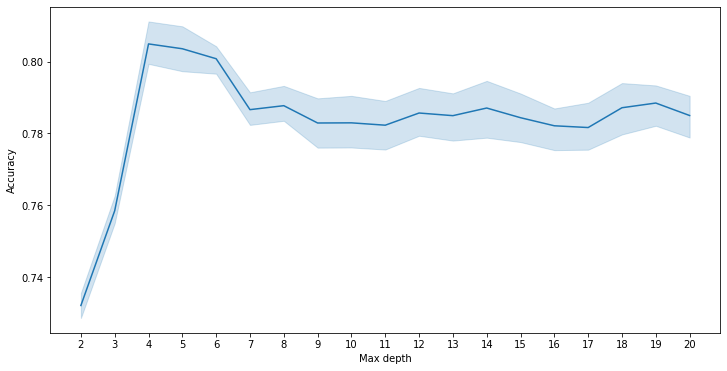

In [106]:
import seaborn as sns
fig,ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=df_scores,x='Max depth',y='Accuracy',ci=99,ax=ax)
a = ax.set_xticks(list(map(int,depths)))

### Generate tree and plot

- generate tree with given max depth = 6 

In [107]:
tree = DecisionTreeClassifier(criterion='entropy',max_depth=6)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.40)
tree = tree.fit(X_train, Y_train)

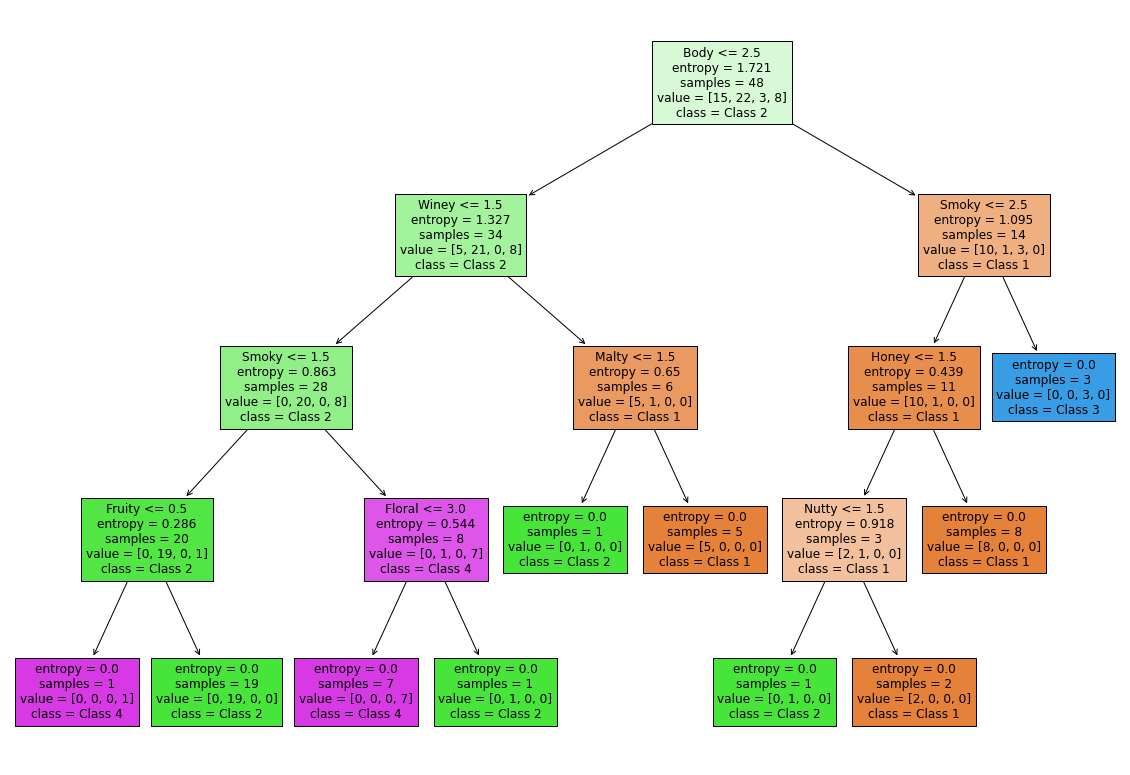

In [110]:
fig = plt.figure(figsize=(20,14))
a = plot_tree(tree, feature_names=X_train.columns.values,
                class_names=['Class 1','Class 2', 'Class 3', 'Class 4'],
                filled=True)

### Confusion matrix

In [39]:
Y_pred = tree.predict(X_test)

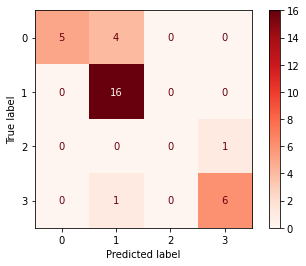

In [40]:
cm = ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred,cmap=plt.cm.Reds)

### Precisison and Recall

In [41]:
print(classification_report(Y_pred,Y_test))

              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       1.00      0.76      0.86        21
           2       0.00      0.00      0.00         0
           3       0.86      0.86      0.86         7

    accuracy                           0.82        33
   macro avg       0.60      0.65      0.61        33
weighted avg       0.90      0.82      0.84        33



___<span style="color:red">
    Work in progress - there is likely insufficient data to progress down this route of evaluation
</span>___

In [42]:
from sklearn.metrics import precision_recall_curve, roc_curve

In [43]:
Y_score = tree.predict_proba(X_test)
Y_test_bin = pd.get_dummies(Y_test).values

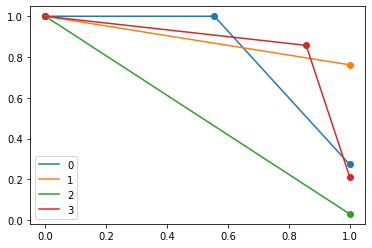

In [44]:
res_dict = {}
for i in range(Y_test.nunique()):
    precision, recall, a = precision_recall_curve(Y_test_bin[:,i],Y_score[:,i])
    res_dict[i] = precision,recall
    plt.plot(recall,precision,label=i)
    plt.scatter(recall,precision)
plt.legend()

### ROC

___<span style="color:red">
   Work in progress - there is likely insufficient data to progress down this route of evaluation
</span>___